# Contrastive divergence for RBM training

In [28]:
import seaborn as sb
import numpy as np
import pdb
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import argparse
import sys
import os
%matplotlib inline

In [29]:
## Set random state to reproduce data
rState = np.random.RandomState(212)
# Load Data
train = np.matrix(np.genfromtxt('digitstrain.txt', delimiter=','))
rState.shuffle(train) ## Shuffle to improve convergence
test = np.matrix(np.genfromtxt('digitstest.txt', delimiter=','))
val = np.matrix(np.genfromtxt('digitsvalid.txt', delimiter=','))

# Removing the class from the dataset

_train = train[:,:-1]
_test = test[:,:-1]
_val = val[:,:-1]

# and thresholding to {0,1}
train = np.round(_train)
test = np.round(_test)
val = np.round(_val)

In [30]:
# Plotting the image 
## The data is in row-major format
def plot_image(train):
  plt.imshow(train[0].reshape((28,28)))
## The image is squeezed row-wise

In [31]:
def softplus(X):
  return np.log(1+np.exp(X))

def sigmoid(mat):
  return 1./(1+ np.exp(-mat))

def cross_entropy_loss(vec, gt):
  return -np.multiply(gt,np.log(vec)).sum()/vec.shape[1] ## take the average

def copy_list(a):
  return [a[i].copy() for i in range(len(a))]

In [32]:
a = np.matrix([[1,2],[3,4]])
b = np.matrix([[1,2],[3,4]])
np.multiply(a,b)

matrix([[ 1,  4],
        [ 9, 16]])

# Visualization

In [33]:
## Visualizing filters
def vis(W, save_name):
  dim = W.shape[1]
  n_image_rows = int(np.ceil(np.sqrt(dim)))
  n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
  gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
  for g,count in zip(gs,range(int(dim))):
    ax = plt.subplot(g)
    ax.imshow(W[:,count].reshape((28,28)))
    ax.set_xticks([])
    ax.set_yticks([])
  plt.savefig(save_name + '_vis.png')

def plot_cce(model, save_name):  
  train_plt = plt.plot(range(len(model.hist.train_loss)),model.hist.train_loss, 'r--', label='Train')
  val_plt = plt.plot(range(len(model.hist.val_loss)),model.hist.val_loss, 'g-', label="Val")
  plt.xlabel('No. of Epochs')
  plt.ylabel('mean(Entropy Loss)')
  plt.savefig(save_name+'.png')

def plot_err(model, save_name):  
  train_plt = plt.plot(range(len(model.hist.train_loss)),model.hist.train_class_loss, 'r--', label='Train')
  val_plt = plt.plot(range(len(model.hist.val_loss)),model.hist.val_class_loss, 'g-', label="Val")
  plt.xlabel('No. of Epochs')
  plt.ylabel('Classification Error')
  plt.savefig(save_name+'_err.png')

# Saving and loading the model

In [34]:
def save_model(model, filename):
  fl = open(filename,'wb')
  pkl.dump(model,fl)
  
def save_weights(model, filename):
  fl = open(filename, 'wb')
  pkl.dump([model.W, model.b, model.c], fl)
  
def load_model(filename):
  fl = open(filename, 'rb')
  return pkl.load(fl)

# Loss History Class

In [35]:
class history(object):
  def __init__(self):
    self.train_loss = list()
    self.val_loss = list()
    
  def add(self,train_loss, val_loss):
    self.train_loss.append(train_loss)
    self.val_loss.append(val_loss)

# Model Class RBM

In [36]:
class RBM(object):
  def __init__(self,graph):
    self.graph = graph
    self.hist = history()
    
    ## initialize the weights
    high = np.sqrt(6.0/(sum(graph)))
    low = -high
    self.W = rState.uniform(low=low,high=high, size=(graph[1],graph[0])) # nXm
    self.b = rState.uniform(low=low,high=high, size=(graph[1],1)) # nX1
    self.c = rState.uniform(low=low,high=high, size=(graph[0],1)) # mX1
    ## p(h=1|x) = sigm(Wx + b)
    ## p(x=1|x) = sigm(W'h + c)
    
    self.W_optimal = copy_list(self.W)

  def restore_optimal_weights(self):
    self.W = copy_list(self.W_optimal)

  def h(self,x):
    return sigmoid(np.matmul(self.W, x) + self.b)
  
  def h_inv(self, h):
    return sigmoid(np.matmul(self.W.T, h) + self.c)
  
  def sample(self,P):
    samples = np.zeros_like(P)
    for index, p in np.ndenumerate(P):
      samples[index] = rState.binomial(1,p)
    return samples
  
  ## MCMC chain to predict a {0,1} output
  def MCMC(self, x, k):
    ## create a MCMC chain
    for i in range(k):
      _h = self.h(x)
      h = self.sample(_h)
      _x = self.h_inv(h)
      x = self.sample(_x)
    
    return x, self.h(x)
  
  ## MCMC chain to predict a continous output
  def generation(self, x, k):
    for i in range(k-1):
      _h = self.h(x)
      h = self.sample(_h)
      _x = self.h_inv(h)
      x = self.sample(_x)
    
    _h = self.h(x)
    h = self.sample(_h)
    _x = self.h_inv(h)
    
    return _x
  
  def train(self, x, k=1, lr=0.01):
    x_cap, h_cap = self.MCMC(x,k)
    _h = self.h(x)
    gradW = np.matmul(_h, x.T) - np.matmul(h_cap,x_cap.T)
    gradb = _h - h_cap
    gradc = x - x_cap
    
    ## gradient updates applied on the weights
    self.W += lr*gradW
    self.b += lr*gradb
    self.c += lr*gradc

In [37]:
def mean_cross_entropy_loss(model, X):
  x_gt = model.sample(X.T)
  x_cap = model.h_inv(model.sample(model.h(x_gt)))
  l = cross_entropy_loss(x_cap, x_gt)
  return l

In [38]:
def sgd_train(args):
  ## automatically creating a savename
  save_name = "%s_k%d_graph_%d" %(args.save_dir, args.num_mcmc,args.graph[1])
  save_name = os.path.join(args.save_dir, save_name)
  
  ## initilizing the rbm model
  rbm = RBM(args.graph)
  for count in tqdm(range(args.num_epochs)):
    for i in range(train.shape[0]):
      rbm.train(train[i].T, k=args.num_mcmc, lr=args.lr)
    ## Calculation of cross entropy loss
    train_loss = mean_cross_entropy_loss(rbm, train)
    val_loss = mean_cross_entropy_loss(rbm, val)
    ## Add loss to the history variable
    rbm.hist.add(train_loss, val_loss)
    print "Epochs:%d Train Loss:%5f Test Loss:%5f" % (count, train_loss, val_loss)
    
  ## plot and save images
  plot_cce(model=rbm, save_name=save_name)
  vis(W=rbm.W.T, save_name=save_name)
  
  ## save model
  save_model(rbm, save_name + '_model.p')
  ## save weights
  save_weights(rbm, save_name + 'weights.p')
  return rbm

In [39]:
def main():
  parser = argparse.ArgumentParser()
  parser.add_argument('--save_dir', type=str, default='save',
                      help='directory to store checkpointed models')
  parser.add_argument('--graph', type=int ,nargs='+', default=[784,100],
                      help='Structure of the NN') 
  parser.add_argument('--prob', type=float, default=1,
                      help='dropout coefficients')
  parser.add_argument('--lam', type=float, default=0,
                      help='regularizing coefficient')
  parser.add_argument('--lr', type=float, default=0.01,
                      help='learning rate')
  parser.add_argument('--num_epochs', type=int, default=1, 
                      help='number of epochs')
  parser.add_argument('--num_mcmc', type=int, default=1, 
                      help='number of mcmc iterations')
  parser.add_argument('--seed', type=int, default=212, 
                      help='Random Seed')
  args = parser.parse_args()
  try:
    os.makedirs(args.save_dir)
  except:
    pass
  model = sgd_train(args)
  return model

 20%|██        | 1/5 [00:22<01:30, 22.54s/it]

Epochs:0 Train Loss:62.946379 Test Loss:64.194699


 40%|████      | 2/5 [00:44<01:07, 22.37s/it]

Epochs:1 Train Loss:52.716429 Test Loss:54.715756


 60%|██████    | 3/5 [01:06<00:44, 22.17s/it]

Epochs:2 Train Loss:48.461023 Test Loss:50.962358


 80%|████████  | 4/5 [01:26<00:21, 21.46s/it]

Epochs:3 Train Loss:45.379598 Test Loss:48.169807


100%|██████████| 5/5 [01:46<00:00, 21.30s/it]

Epochs:4 Train Loss:42.782142 Test Loss:46.085953


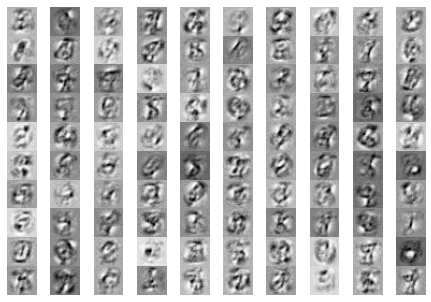

In [40]:
sys.argv=['train.py',
         '--save_dir','model',
         '--graph', '784', '100',
         '--lr', '0.01',
         '--num_epochs', '5',
         '--num_mcmc', '1',
         '--seed', '212']
#if __name__=="__main__":
model = main()

In [72]:
X = np.random.normal(size=train[0].T.shape)
X_cap = model.generation(X,1000)
X_cap1 = model.generation(X,1)

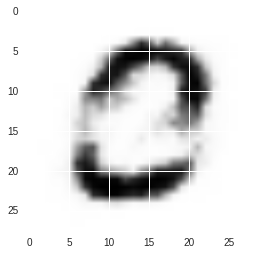

In [73]:
plot_image(X_cap.T)

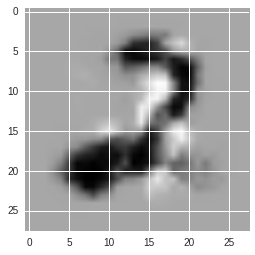

In [71]:
plot_image(X_cap.T - X_cap1.T)

In [ ]:
vis(model.W.T, '1')

In [ ]:
model.W.T.shape

In [ ]:
X_cap = model.generation(test[1000].T,5)
plot_image(X_cap.T)